In [61]:
import os 
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split    
from keras.utils import to_categorical


In [62]:
data_dir = 'data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

print(sorted(classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [63]:
X = []
y = []

for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    print(f'{c}: {len(files)}')

    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        # Check the shape of the image after resizing
        print(img.shape)
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

9: 100
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 4)
(28, 28, 

In [64]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('classes.npy', classes)

print('Data saved')


(1000, 28, 28, 4)
(1000,)
Data saved


In [65]:
# Load the data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(sorted(classes))



Data loaded
(800, 28, 28, 4)
(200, 28, 28, 4)
(800, 10)
(200, 10)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


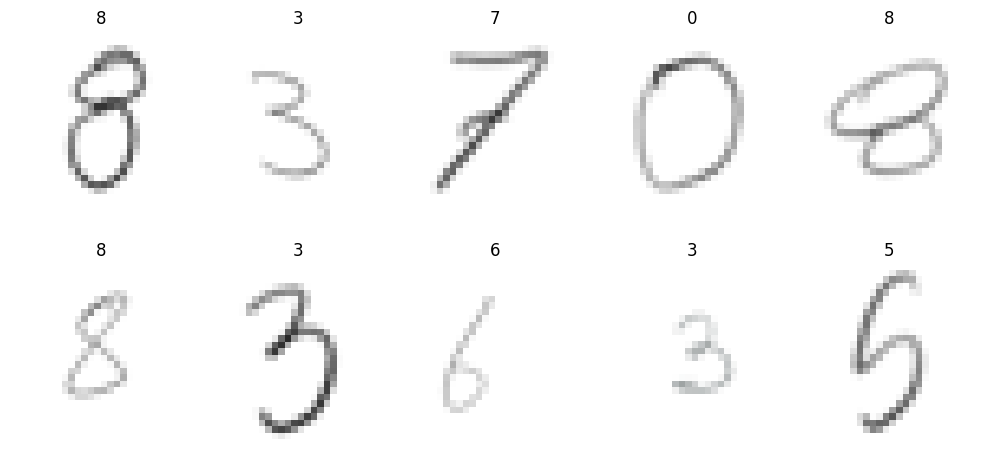

In [66]:
# print a random sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
from keras.optimizers import legacy
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report


In [74]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), padding="valid", activation='relu', input_shape=(28, 28, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

print("******* training network *******")
sgd = legacy.SGD(learning_rate= 0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,
	metrics=["accuracy"])
# go through the data 5 times with 128 batch sizes
H = model.fit(X_train, y_train, validation_data=(X_test, y_test),
	epochs=10, batch_size=20)

# evaluate the network
print("******* evaluating network *******")
predictions = model.predict(X_test, batch_size=20)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1)))

******* training network *******
Epoch 1/10
40/40 [==============================] - 2s 24ms/step - loss: 2.3071 - accuracy: 0.1037 - val_loss: 2.3072 - val_accuracy: 0.0700
Epoch 2/10
40/40 [==============================] - 1s 13ms/step - loss: 2.3002 - accuracy: 0.1112 - val_loss: 2.3111 - val_accuracy: 0.0650
Epoch 3/10
40/40 [==============================] - 1s 18ms/step - loss: 2.2944 - accuracy: 0.1363 - val_loss: 2.3020 - val_accuracy: 0.0900
Epoch 4/10
40/40 [==============================] - 1s 15ms/step - loss: 2.2425 - accuracy: 0.2350 - val_loss: 2.1834 - val_accuracy: 0.2850
Epoch 5/10
40/40 [==============================] - 1s 13ms/step - loss: 1.9444 - accuracy: 0.3475 - val_loss: 2.2073 - val_accuracy: 0.1650
Epoch 6/10
40/40 [==============================] - 1s 13ms/step - loss: 1.8830 - accuracy: 0.3438 - val_loss: 1.5585 - val_accuracy: 0.5250
Epoch 7/10
40/40 [==============================] - 1s 13ms/step - loss: 1.2830 - accuracy: 0.5863 - val_loss: 1.1712 - v